# Installations

In [ ]:
# Installations

# install once necessary libraries

!pip install pandas
!pip install -U scikit-learn
!pip install pm4py
!pip install kneed
!pip install torch

# Import Event Log

In [1]:
import pandas as pd
import numpy as np
import pm4py
from pm4py.objects.conversion.log import converter as log_converter

if __name__ == "__main__":
    # Read the XES file
    dataframe = pm4py.read_xes('RequestForPayment.xes')

    # If 'log' is already a DataFrame, add the @@case_index column directly
    case_indices = {case_id: idx for idx, case_id in enumerate(dataframe['case:concept:name'].unique())}
    dataframe['@@case_index'] = dataframe['case:concept:name'].map(case_indices)
    
     # Convert the dataframe to event log
    log = log_converter.apply(dataframe)
    
dataframe

parsing log, completed traces ::   0%|          | 0/6886 [00:00<?, ?it/s]

/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[co

,id,org:resource,concept:name,time:timestamp,org:role,case:Rfp_id,case:Project,case:Task,case:concept:name,case:OrganizationalEntity,case:Cost Type,case:RequestedAmount,case:Activity,case:RfpNumber,@@case_index
0,st_step 148220_0,STAFF MEMBER,Request For Payment SUBMITTED by EMPLOYEE,2017-01-09 08:17:18+00:00,EMPLOYEE,request for payment 148214,project 148216,UNKNOWN,request for payment 148214,organizational unit 65463,0,34.336343,UNKNOWN,request for payment number 148215,0
1,st_step 148221_0,STAFF MEMBER,Request For Payment FINAL_APPROVED by SUPERVISOR,2017-01-09 08:18:00+00:00,SUPERVISOR,request for payment 148214,project 148216,UNKNOWN,request for payment 148214,organizational unit 65463,0,34.336343,UNKNOWN,request for payment number 148215,0
2,st_step 148222_0,STAFF MEMBER,Request For Payment REJECTED by MISSING,2017-01-10 11:42:32+00:00,MISSING,request for payment 148214,project 148216,UNKNOWN,request for payment 148214,organizational unit 65463,0,34.336343,UNKNOWN,request for payment number 148215,0
3,st_step 148219_0,STAFF MEMBER,Request For Payment SUBMITTED by EMPLOYEE,2017-03-03 08:51:13+00:00,EMPLOYEE,request for payment 148214,project 148216,UNKNOWN,request for payment 148214,organizational unit 65463,0,34.336343,UNKNOWN,request for payment number 148215,0
4,st_step 148218_0,STAFF MEMBER,Request For Payment APPROVED by PRE_APPROVER,2017-03-03 08:51:42+00:00,PRE_APPROVER,request for payment 148214,project 148216,UNKNOWN,request for payment 148214,organizational unit 65463,0,34.336343,UNKNOWN,request for payment number 148215,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36791,st_step 185004_0,STAFF MEMBER,Request For Payment APPROVED by ADMINISTRATION,2018-12-29 11:35:02+00:00,ADMINISTRATION,request for payment 185000,project 147860,task 152704,request for payment 185000,organizational unit 65468,0,15.409660,activity 505,request for payment number 185001,6885
36792,st_step 185003_0,STAFF MEMBER,Request For Payment APPROVED by BUDGET OWNER,2019-01-03 08:27:20+00:00,BUDGET OWNER,request for payment 185000,project 147860,task 152704,request for payment 185000,organizational unit 65468,0,15.409660,activity 505,request for payment number 185001,6885
36793,st_step 185005_0,STAFF MEMBER,Request For Payment FINAL_APPROVED by SUPERVISOR,2019-01-08 08:00:39+00:00,SUPERVISOR,request for payment 185000,project 147860,task 152704,request for payment 185000,organizational unit 65468,0,15.409660,activity 505,request for payment number 185001,6885
36794,rp_request for payment 185000_15,SYSTEM,Request Payment,2019-01-08 08:29:14+00:00,UNDEFINED,request for payment 185000,project 147860,task 152704,request for payment 185000,organizational unit 65468,0,15.409660,activity 505,request for payment number 185001,6885


# Data Preprocessing

In [2]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np

q = 10

# Group the dataframe by case and combine the activities into a list
grouped = dataframe.groupby('@@case_index')['concept:name'].apply(list).reset_index(name='traces')

# Convert all activities to lowercase for consistency
grouped['traces'] = grouped['traces'].apply(lambda x: [activity.lower() for activity in x])

# Train a Word2Vec model
model = Word2Vec(sentences=grouped['traces'], vector_size=q, window=5, min_count=1, workers=4)

# Function to concatenate and pad vectors of each activity in a trace
def trace_to_padded_vector(trace, model, max_length, vector_size=q):
    # Get the vector for each activity in the trace
    vectors = [model.wv[activity] for activity in trace if activity in model.wv]
    
    # Concatenate all vectors
    concatenated_vector = np.concatenate(vectors) if vectors else np.zeros(0)

    # Determine the length of padding required
    padding_length = max_length - concatenated_vector.shape[0]

    # Check if padding is needed
    if padding_length > 0:
        # Pad with zeros
        concatenated_vector = np.pad(concatenated_vector, (0, padding_length), mode='constant')
    elif padding_length < 0:
        # Truncate the vector if it's longer than max_length
        concatenated_vector = concatenated_vector[:max_length]

    return concatenated_vector

# Determine the maximum length for padding (you might need to adjust this)
# Example: max_length = longest trace * vector_size
max_length = max(grouped['traces'].apply(len)) * q

# Map each trace to its concatenated and padded vector representation
padded_trace_vectors = grouped['traces'].apply(lambda x: trace_to_padded_vector(x, model, max_length))

trace_vectors = padded_trace_vectors

# Clustering

/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default 

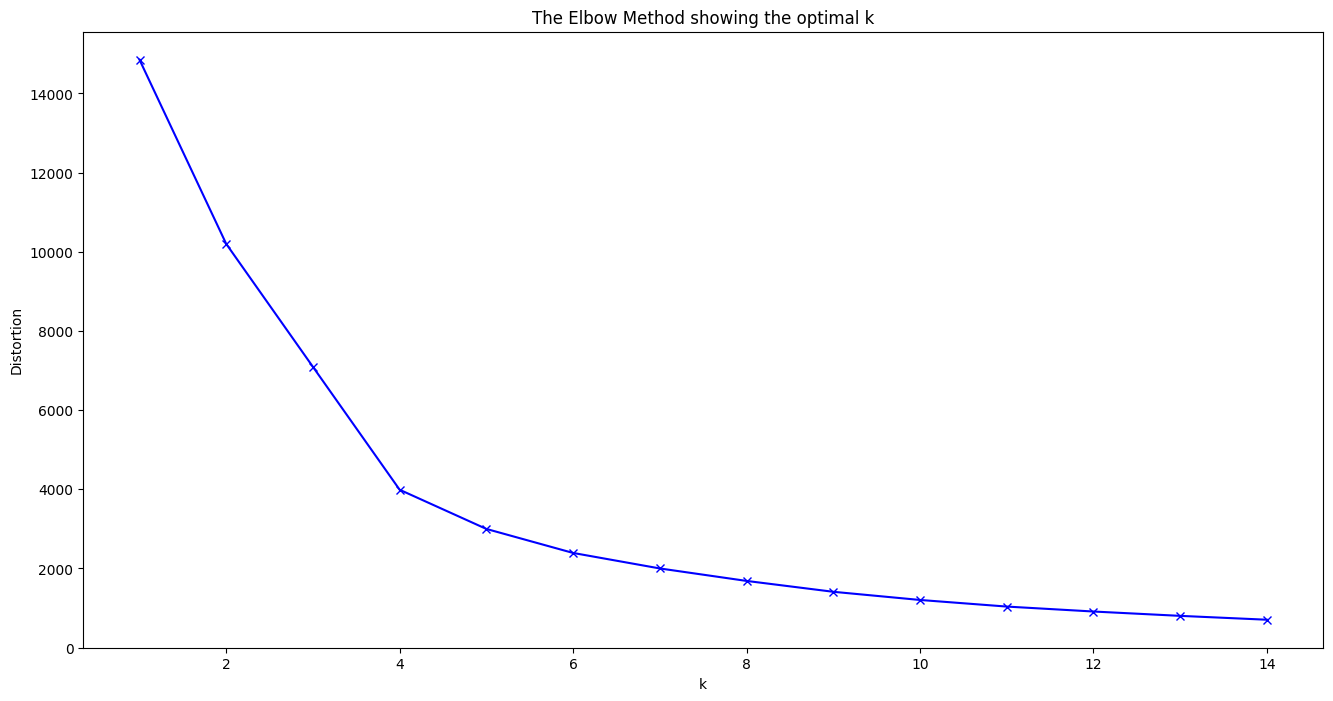

Optimal number of clusters: 4


In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
import numpy as np

# Convert trace_vectors into a 2D array, which can be directly fed to KMeans
trace_vectors = np.array(trace_vectors.tolist())

distortions = []
K = range(1, 15)  # Check for number of clusters from 1 to 15, adjust according to your data
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(trace_vectors)
    distortions.append(kmeans.inertia_)  # Inertia: sum of squared distances of samples to their closest cluster center

# Plot the elbow
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Find the elbow point using KneeLocator
kl = KneeLocator(K, distortions, curve='convex', direction='decreasing')
print("Optimal number of clusters:", kl.elbow)

In [4]:
from sklearn.cluster import KMeans

# Number of clusters
k = kl.elbow

# Create a KMeans instance with k clusters
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model to the data
kmeans.fit(trace_vectors)

# Predict the clusters for each trace
clusters = kmeans.predict(trace_vectors)

/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Cluster Evaluation

In [5]:
# the value of the silhouette coefficient ranges between -1 and 1
# value close to 1 is considered as good

from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(trace_vectors, clusters)

print(f"Silhouette Coefficient: {silhouette_avg:.2f}")

Silhouette Coefficient: 0.80


# Token-Based Replay for Conformance Checking

In [6]:
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments_petri

# 2. Import the given BPMN model
bpmn_graph = bpmn_importer.apply("Model_RequestForPayment.bpmn")

# 3. Convert the BPMN to a Petri net
net, im, fm = pm4py.convert_to_petri_net(bpmn_graph)

# 4. Perform alignment-based conformance checking
alignments = alignments_petri.apply(log, net, im, fm)

# Calculate and print diagnostics
fit_traces = sum(1 for trace in alignments if trace['fitness'] == 1.0)

print(f"Total traces: {len(log)}")
print(f"Conform traces: {fit_traces}")
print(f"Non-Conform traces: {len(log) - fit_traces}")

replaying log with TBR, completed variants ::   0%|          | 0/89 [00:00<?, ?it/s]

Total traces: 6886
Conform traces: 5191
Non-Conform traces: 1695


# Input Traces

In [7]:
trace1 = ['Request For Payment SUBMITTED by EMPLOYEE', 'Request For Payment APPROVED by ADMINISTRATION', 'Request For Payment FINAL_APPROVED by SUPERVISOR', 'Request Payment', 'Payment Handled']
trace2 = ['Request For Payment SUBMITTED by EMPLOYEE', 'Request For Payment APPROVED by ADMINISTRATION', 'Request For Payment APPROVED by BUDGET OWNER', 'Request For Payment FINAL_APPROVED by SUPERVISOR', 'Request Payment', 'Payment Handled']
trace3 = ['Request For Payment SUBMITTED by EMPLOYEE', 'Request For Payment REJECTED by ADMINISTRATION', 'Request For Payment REJECTED by EMPLOYEE']

In [8]:
grouped = dataframe.groupby('@@case_index')['concept:name'].apply(list).reset_index(name='trace')

In [9]:
def is_happy_trace(row_trace):
    predefined_traces = [trace1, trace2, trace3]
    for trace in predefined_traces:
        if row_trace == trace:
            return 1
    return 0

In [10]:
grouped['happy'] = grouped['trace'].apply(is_happy_trace)
grouped

,@@case_index,trace,happy
0,0,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",0
1,1,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",0
2,2,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",0
3,3,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",0
4,4,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",0
...,...,...,...
6881,6881,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",1
6882,6882,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",1
6883,6883,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",1
6884,6884,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",1


In [11]:
# Get indices of the happy traces in the results dataframe
happy_trace_indices = grouped[grouped['happy'] == 1].index.tolist()

# Extract the corresponding coordinates from the trace_representations array
happy_trace_coordinates = trace_vectors[happy_trace_indices]

# Extract unique coordinates
unique_happy_trace_coordinates = np.unique(happy_trace_coordinates, axis=0)

# Assuming the size of unique_happy_trace_coordinates is 3
#happy_trace1, happy_trace2, happy_trace3 = unique_happy_trace_coordinates
happy_trace1, happy_trace2, happy_trace3 = unique_happy_trace_coordinates

# Distance Measurement

In [12]:
from scipy.spatial.distance import euclidean

# Calculate the distances to each of the happy traces for every trace representation
distances_to_happy_traces = []

for trace_representation in trace_vectors:
    distances = [
        euclidean(trace_representation, happy_trace1),
        euclidean(trace_representation, happy_trace2),
        euclidean(trace_representation, happy_trace3)
    ]
    distances_to_happy_traces.append(distances)

# Calculate the average distance to the happy traces for each trace representation
avg_distances = [np.mean(distances) for distances in distances_to_happy_traces]

# Save the distances in a variable
avg_distances_var = np.array(avg_distances)

# Results overview

In [13]:
# create dataframe with necessary information for distance measurement

#grouped = dataframe.groupby('@@case_index')['concept:name'].apply(list).reset_index(name='trace')

results = pd.DataFrame(grouped['trace'])

results['cluster'] = clusters

conformity_array = [int(trace['fitness']) for trace in alignments]
results['conform'] = conformity_array

results['distance'] = avg_distances_var

results

,trace,cluster,conform,distance
0,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",3,0,2.770353
1,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",2,0,2.222789
2,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",3,0,2.618913
3,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",3,0,2.770353
4,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",3,0,2.770353
...,...,...,...,...
6881,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",0,1,1.533837
6882,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",0,1,1.533837
6883,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",0,1,1.533837
6884,"[Request For Payment SUBMITTED by EMPLOYEE, Re...",1,1,1.612675


In [14]:
summary = results.groupby('cluster').agg(
    count=pd.NamedAgg(column='trace', aggfunc='size'),
    conform_count=pd.NamedAgg(column='conform', aggfunc='sum')
).reset_index()

print("cluster\tcount\tconform_count")
for _, row in summary.iterrows():
    print(f"{row['cluster']}\t{row['count']}\t{row['conform_count']}")

cluster	count	conform_count
0	3372	3017
1	1791	1786
2	1122	380
3	601	8


# Evaluation

/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


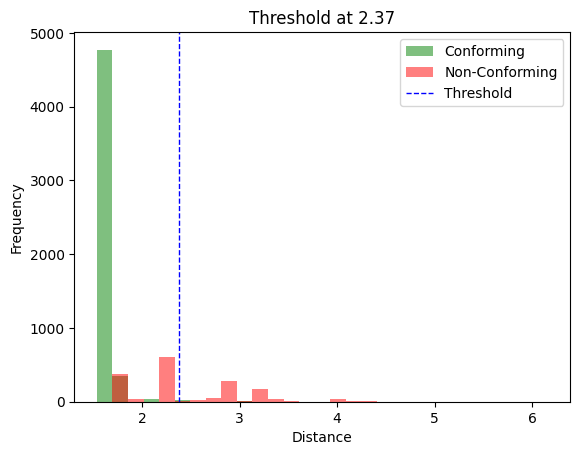

In [15]:
from sklearn.cluster import KMeans

# Filter the DataFrame into conforming and non-conforming subsets
conforming_distances = results[results['conform'] == 1]['distance']
non_conforming_distances = results[results['conform'] == 0]['distance']

# Determine common bin edges
min_distance = min(results['distance'])
max_distance = max(results['distance'])
bin_edges = np.linspace(min_distance, max_distance, num=30)

# Combine the data and reshape for k-means
all_distances = results['distance']
all_distances = np.array(all_distances)
all_distances_reshaped = all_distances.reshape(-1, 1)

# Apply k-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(all_distances_reshaped)
kmeans_labels = kmeans.labels_

# Find the threshold as the average of the two cluster centers
threshold_value = np.mean(kmeans.cluster_centers_)

# Plot histograms and the threshold
plt.hist(conforming_distances, bins=bin_edges, alpha=0.5, label='Conforming', color='green')
plt.hist(non_conforming_distances, bins=bin_edges, alpha=0.5, label='Non-Conforming', color='red')
plt.axvline(threshold_value, color='blue', linestyle='dashed', linewidth=1, label='Threshold')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title(f'Threshold at {threshold_value:.2f}')
plt.show()

In [16]:
true_positive = np.sum(results[results['conform'] == 1]['distance'] < threshold_value)
true_negative = np.sum(results[results['conform'] == 0]['distance'] > threshold_value)
false_positive = np.sum(results[results['conform'] == 0]['distance'] < threshold_value)
false_negative = np.sum(results[results['conform'] == 1]['distance'] > threshold_value)

In [17]:
# Calculate accuracy
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.846


In [18]:
# Calculate precision
precision = true_positive / (true_positive + false_positive)
print(f"Precision: {precision:.3f}")

Precision: 0.834


In [19]:
# Calculate recall
recall = true_positive / (true_positive + false_negative)
print(f"Recall: {recall:.3f}")

Recall: 0.993


In [20]:
# Calculate f1
f1 = 2 * ((precision * recall) / (precision + recall))
print(f"F1: {f1:.3f}")

F1: 0.907


# Dev (Non Conform Traces)

In [21]:
# Calculate precision for Dev
precision = true_negative / (true_negative + false_negative)
print(f"Precision: {precision:.3f}")

Precision: 0.950


In [22]:
# Calculate recall for Dev
recall = true_negative / (true_negative + false_positive)
print(f"Recall: {recall:.3f}")

Recall: 0.395


# No Dev (Conform Traces)

In [23]:
# Calculate precision for No Dev
precision = true_positive / (true_positive + false_positive)
print(f"Precision: {precision:.3f}")

Precision: 0.834


In [24]:
# Calculate recall for No Dev
recall = true_positive / (true_positive + false_negative)
print(f"Recall: {recall:.3f}")

Recall: 0.993


# AUC_ROC

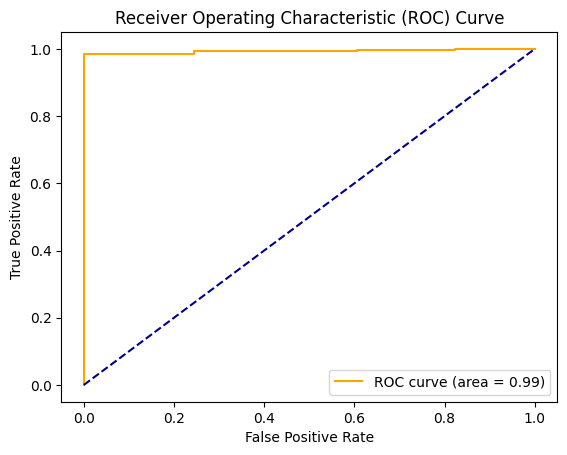

ROC AUC: 0.993


In [25]:
# UPDATED

import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming 'results' is your DataFrame and 'distance' is the score to predict conformity

# Inverting the 'distance' scores because higher scores indicate non-conformity
# We invert the scores for ROC AUC calculation because roc_auc_score expects higher values
# to indicate higher likelihood of the positive class
inverted_scores = 1 - results['distance']

# Calculate the ROC curve and AUC using inverted scores
fpr, tpr, thresholds = roc_curve(results['conform'], inverted_scores, pos_label=1)
roc_auc = roc_auc_score(results['conform'], inverted_scores)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC
print(f"ROC AUC: {roc_auc:.3f}")